## Fine-tuning Stable Diffusion XL with DreamBooth and LoRA on a free-tier Colab Notebook 🧨

In this notebook, we show how to fine-tune [Stable Diffusion XL (SDXL)](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/stable_diffusion_xl) with [DreamBooth](https://huggingface.co/docs/diffusers/main/en/training/dreambooth) and [LoRA](https://huggingface.co/docs/diffusers/main/en/training/lora) on a T4 GPU.

SDXL consists of a much larger UNet and two text encoders that make the cross-attention context quite larger than the previous variants.

So, to pull this off, we will make use of several tricks such as gradient checkpointing, mixed-precision, and 8-bit Adam. So, hang tight and let's get started 🧪

## Setup 🪓

In [2]:
# Check the GPU
!nvidia-smi

Mon Apr  7 04:43:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             25W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# Install dependencies.
!pip install bitsandbytes transformers accelerate peft -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 MB 21.7 MB/s eta 0:00:00:00:0100:01


Make sure to install `diffusers` from `main`.

In [4]:
!pip install git+https://github.com/huggingface/diffusers.git -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Download diffusers SDXL DreamBooth training script.

In [5]:
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py

--2025-04-07 04:43:44--  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84961 (83K) [text/plain]
Saving to: ‘train_dreambooth_lora_sdxl.py’

train_dreambooth_lo 100%[===================>]  82.97K  --.-KB/s    in 0.007s  

2025-04-07 04:43:44 (10.8 MB/s) - ‘train_dreambooth_lora_sdxl.py’ saved [84961/84961]



## Dataset 🐶

**Let's get our training data!**
For this example, we'll download some images from the hub

If you already have a dataset on the hub you wish to use, you can skip this part and go straight to: "Prep for
training 💻" section, where you'll simply specify the dataset name.

If your images are saved locally, and/or you want to add BLIP generated captions,
pick option 1 or 2 below.



**Option 1:** upload example images from your local files:

**Option 2:** download example images from the hub:

In [6]:
!ls /kaggle/input/mobiset

100.jpg  11.jpg  21.jpg  31.jpg  42.jpg  52.jpg  63.jpg  74.jpg  84.jpg  94.jpg
101.jpg  12.jpg  22.jpg  32.jpg  43.jpg  53.jpg  64.jpg  75.jpg  85.jpg  95.jpg
102.jpg  13.jpg  23.jpg  33.jpg  44.jpg  55.jpg  65.jpg  76.jpg  86.jpg  96.jpg
103.jpg  14.jpg  24.jpg  34.jpg  45.jpg  56.jpg  66.jpg  77.jpg  87.jpg  97.jpg
104.jpg  15.jpg  25.jpg  36.jpg  46.jpg  57.jpg  67.jpg  78.jpg  88.jpg  98.jpg
105.jpg  16.jpg  26.jpg  37.jpg  47.jpg  58.jpg  68.jpg  79.jpg  89.jpg  99.jpg
106.jpg  17.jpg  27.jpg  38.jpg  48.jpg  59.jpg  69.jpg  7.jpg	 8.jpg	 9.jpg
107.jpg  18.jpg  28.jpg  39.jpg  49.jpg  5.jpg	 6.jpg	 80.jpg  90.jpg
108.jpg  19.jpg  29.jpg  3.jpg	 4.jpg	 60.jpg  70.jpg  81.jpg  91.jpg
109.jpg  1.jpg	 2.jpg	 40.jpg  50.jpg  61.jpg  72.jpg  82.jpg  92.jpg
10.jpg	 20.jpg  30.jpg  41.jpg  51.jpg  62.jpg  73.jpg  83.jpg  93.jpg


In [9]:
!mkdir mobiss
!cp /kaggle/input/mobiset/* mobiss

Preview the images:

In [10]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):
    if not imgs:
        print("Нет изображений для отображения.")
        return None

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    
    return grid

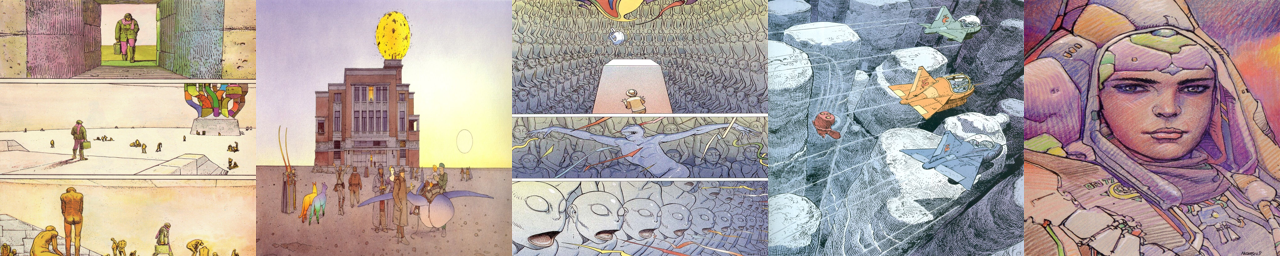

In [11]:
import glob

# change path to display images from your local dir
img_paths = "./mobiss/*.jpg"
imgs = [Image.open(path) for path in glob.glob(img_paths)]

num_imgs_to_preview = 5
image_grid(imgs[:num_imgs_to_preview], 1, num_imgs_to_preview)

### Generate custom captions with BLIP
Load BLIP to auto caption your images:

In [12]:
import requests
from transformers import AutoProcessor, BlipForConditionalGeneration
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# load the processor and the captioning model
blip_processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base",torch_dtype=torch.float16).to(device)

# captioning utility
def caption_images(input_image):
    inputs = blip_processor(images=input_image, return_tensors="pt").to(device, torch.float16)
    pixel_values = inputs.pixel_values

    generated_ids = blip_model.generate(pixel_values=pixel_values, max_length=50)
    generated_caption = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_caption

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [14]:
import glob
from PIL import Image

# create a list of (Pil.Image, path) pairs
local_dir = "./mobiss/"
imgs_and_paths = [(path,Image.open(path)) for path in glob.glob(f"{local_dir}*.jpg")]

Now let's add the concept token identifier (e.g. TOK) to each caption using a caption prefix.
Feel free to change the prefix according to the concept you're training on!
- for this example we can use "a photo of TOK," other options include:
    - For styles - "In the style of TOK"
    - For faces - "photo of a TOK person"
- You can add additional identifiers to the prefix that can help steer the model in the right direction.
-- e.g. for this example, instead of "a photo of TOK" we can use "a photo of TOK dog" / "a photo of TOK corgi dog"

In [15]:
import json

caption_prefix = "paintings in Moebious style, " #@param
with open(f'{local_dir}metadata.jsonl', 'w') as outfile:
  for img in imgs_and_paths:
      caption = caption_prefix + caption_images(img[1]).split("\n")[0]
      entry = {"file_name":img[0].split("/")[-1], "prompt": caption}
      json.dump(entry, outfile)
      outfile.write('\n')

In [16]:
!cat mobiss/metadata.jsonl

{"file_name": "94.jpg", "prompt": "paintings in Moebious style, a comic strip with a bunch of people"}
{"file_name": "21.jpg", "prompt": "paintings in Moebious style, a drawing of people in front of a building"}
{"file_name": "75.jpg", "prompt": "paintings in Moebious style, a comic strip strip strip strip strip strip strip strip strip strip strip strip strip strip strip strip strip strip strip"}
{"file_name": "44.jpg", "prompt": "paintings in Moebious style, a cartoon drawing of a man in a suit and tie"}
{"file_name": "86.jpg", "prompt": "paintings in Moebious style, a drawing of a woman in a military uniform"}
{"file_name": "61.jpg", "prompt": "paintings in Moebious style, a painting of a woman in a blue dress"}
{"file_name": "9.jpg", "prompt": "paintings in Moebious style, a drawing of a woman with many things on her head"}
{"file_name": "12.jpg", "prompt": "paintings in Moebious style, a cartoon of a man on a road surrounded by monsters"}
{"file_name": "80.jpg", "prompt": "painting

Free some memory:

In [17]:
import gc

# delete the BLIP pipelines and free up some memory
del blip_processor, blip_model
gc.collect()
torch.cuda.empty_cache()

## Prep for training 💻

Initialize `accelerate`:

In [18]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!accelerate config default

accelerate configuration saved at /root/.cache/huggingface/accelerate/default_config.yaml


### Log into your Hugging Face account
Pass [your **write** access token](https://huggingface.co/settings/tokens) so that we can push the trained checkpoints to the Hugging Face Hub:

In [19]:
from huggingface_hub import notebook_login
notebook_login()

## Train! 🔬

#### Set Hyperparameters ⚡
To ensure we can DreamBooth with LoRA on a heavy pipeline like Stable Diffusion XL, we're using:

* Gradient checkpointing (`--gradient_accumulation_steps`)
* 8-bit Adam (`--use_8bit_adam`)
* Mixed-precision training (`--mixed-precision="fp16"`)

### Launch training 🚀🚀🚀

To allow for custom captions we need to install the `datasets` library, you can skip that if you want to train solely
 with `--instance_prompt`.
In that case, specify `--instance_data_dir` instead of `--dataset_name`

In [20]:
!pip install datasets -q

 - Use `--output_dir` to specify your LoRA model repository name!
 - Use `--caption_column` to specify name of the cpation column in your dataset. In this example we used "prompt" to
 save our captions in the
 metadata file, change this according to your needs.

In [24]:
#!/usr/bin/env bash
!accelerate launch train_dreambooth_lora_sdxl.py \
  --pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0" \
  --pretrained_vae_model_name_or_path="madebyollin/sdxl-vae-fp16-fix" \
  --dataset_name="mobiss" \
  --output_dir="mobious_style_LoRA" \
  --caption_column="prompt"\
  --mixed_precision="fp16" \
  --instance_prompt="paintings in Moebious style" \
  --resolution=512 \
  --train_batch_size=2 \
  --gradient_accumulation_steps=3 \
  --gradient_checkpointing \
  --learning_rate=1e-4 \
  --snr_gamma=5.0 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --max_train_steps=1000 \
  --checkpointing_steps=500 \
  --seed="0"

2025-04-07 04:54:15.240337: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-07 04:54:15.259539: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-07 04:54:15.265405: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'dynamic_thresholding_ratio', 'clip_sample_range', '

In [25]:
!ls mobious_style_LoRA

checkpoint-1000  checkpoint-500  logs  pytorch_lora_weights.safetensors


### Save your model to the hub and check it out 🔥

In [26]:
from huggingface_hub import whoami
from pathlib import Path
#@markdown make sure the `output_dir` you specify here is the same as the one used for training
output_dir = "mobious_style_LoRA" #@param
username = whoami(token=Path("/root/.cache/huggingface/"))["name"]
repo_id = f"{username}/{output_dir}"

In [27]:
# @markdown Sometimes training finishes succesfuly (i.e. a **.safetensores** file with the LoRA weights saved properly to your local `output_dir`) but there's not enough RAM in the free tier to push the model to the hub 🙁
# @markdown
# @markdown To mitigate this, run this cell with your training arguments to make sure your model is uploaded! 🤗

# push to the hub🔥
from train_dreambooth_lora_sdxl import save_model_card
from huggingface_hub import upload_folder, create_repo

repo_id = create_repo(repo_id, exist_ok=True).repo_id

# change the params below according to your training arguments
save_model_card(
    repo_id = repo_id,
    images=[],
    base_model="stabilityai/stable-diffusion-xl-base-1.0",
    train_text_encoder=False,
    instance_prompt="paintings in Moebious style",
    validation_prompt=None,
    repo_folder=output_dir,
    use_dora = False,
    vae_path="madebyollin/sdxl-vae-fp16-fix",
)

upload_folder(
    repo_id=repo_id,
    folder_path=output_dir,
    commit_message="End of training",
    ignore_patterns=["step_*", "epoch_*"],
)

optimizer.bin:   0%|          | 0.00/15.1M [00:00<?, ?B/s]

scheduler.bin:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/988 [00:00<?, ?B/s]

pytorch_lora_weights.safetensors:   0%|          | 0.00/23.4M [00:00<?, ?B/s]

random_states_0.pkl:   0%|          | 0.00/14.3k [00:00<?, ?B/s]

Upload 13 LFS files:   0%|          | 0/13 [00:00<?, ?it/s]

optimizer.bin:   0%|          | 0.00/15.1M [00:00<?, ?B/s]

pytorch_lora_weights.safetensors:   0%|          | 0.00/23.4M [00:00<?, ?B/s]

random_states_0.pkl:   0%|          | 0.00/14.3k [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/988 [00:00<?, ?B/s]

scheduler.bin:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

events.out.tfevents.1744001711.28458a8561f5.207.1:   0%|          | 0.00/3.31k [00:00<?, ?B/s]

events.out.tfevents.1744001711.28458a8561f5.207.0:   0%|          | 0.00/247k [00:00<?, ?B/s]

pytorch_lora_weights.safetensors:   0%|          | 0.00/23.4M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/svxesen/mobious_style_LoRA/commit/21d852ddf7fa8c873ab4a52af547850a0db45888', commit_message='End of training', commit_description='', oid='21d852ddf7fa8c873ab4a52af547850a0db45888', pr_url=None, repo_url=RepoUrl('https://huggingface.co/svxesen/mobious_style_LoRA', endpoint='https://huggingface.co', repo_type='model', repo_id='svxesen/mobious_style_LoRA'), pr_revision=None, pr_num=None)

In [35]:
from IPython.display import display, Markdown

link_to_model = f"https://huggingface.co/{repo_id}"
display(Markdown("### Your model has finished training.\nAccess it here: {}".format(link_to_model)))

### Your model has finished training.
Access it here: https://huggingface.co/svxesen/mobious_style_LoRA

Let's generate some images with it!

## Inference 🐕

In [36]:
import torch
from diffusers import DiffusionPipeline, AutoencoderKL

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True
)
pipe.load_lora_weights(repo_id)
_ = pipe.to("cuda")

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

pytorch_lora_weights.safetensors:   0%|          | 0.00/23.4M [00:00<?, ?B/s]

No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
No LoRA keys associated to CLIPTextModelWithProjection found with the prefix='text_encoder_2'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModelWithProjection related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


  0%|          | 0/100 [00:00<?, ?it/s]

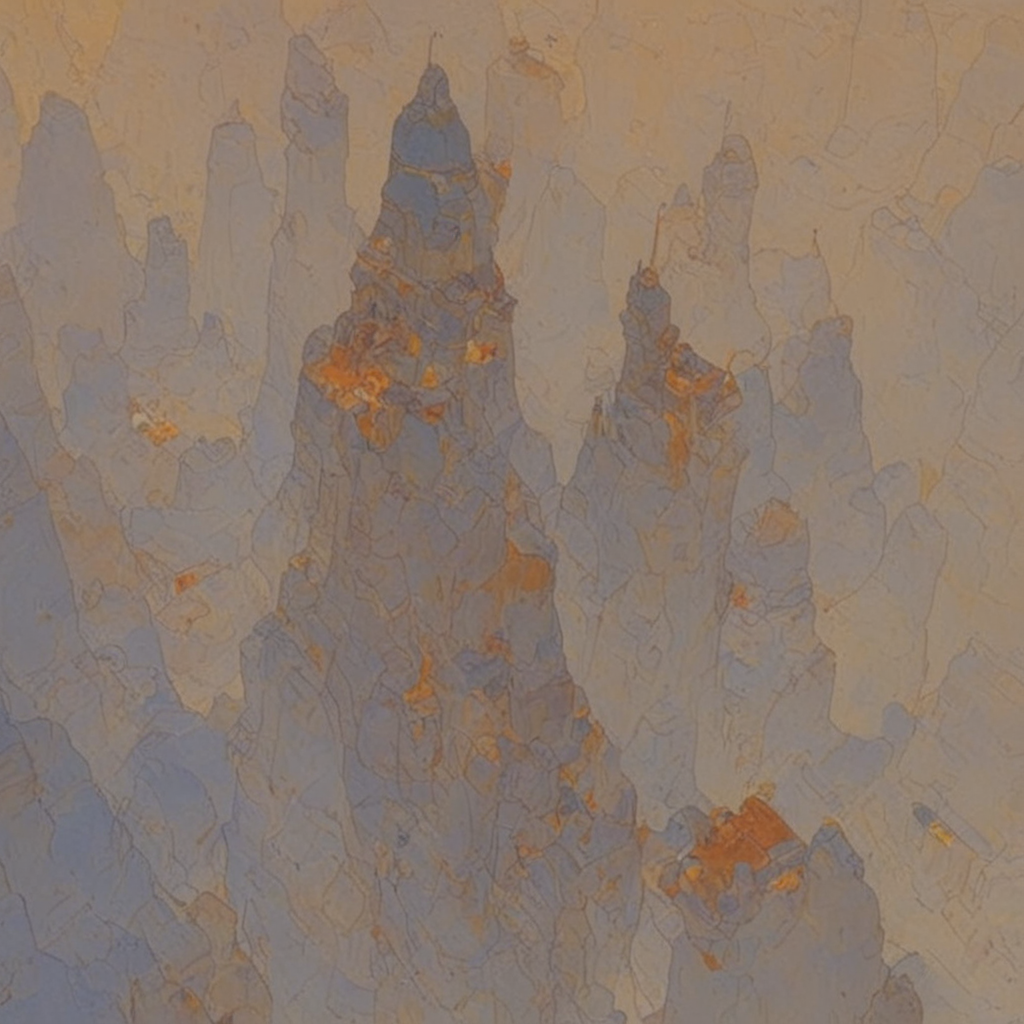

In [41]:
prompt = "paintings in Moebious style, city building, high rising" # @param

image = pipe(prompt=prompt, num_inference_steps=25, 
            cross_attention_kwargs={"scale": 0.5}).images[0]
image